In [1]:
from torchvision.datasets import MNIST

In [2]:
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

In [4]:
import torch

def one_hot_encode(label, num_classes=10):
    return torch.eye(num_classes)[label]

target_transform = transforms.Compose([
    transforms.Lambda(lambda y: torch.tensor(y).clone().detach()),
    transforms.Lambda(one_hot_encode),
])

In [5]:
train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)

In [6]:
type(train_dataset)

torchvision.datasets.mnist.MNIST

In [7]:
image, label = train_dataset[0]

In [8]:
print(type(image))
print(image.shape)

print(type(label))
print(label)

<class 'torch.Tensor'>
torch.Size([784])
<class 'int'>
5


In [9]:
import matplotlib.pyplot as plt

In [10]:
pil_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.view(1, 28, 28)),
    transforms.ToPILImage(),
])

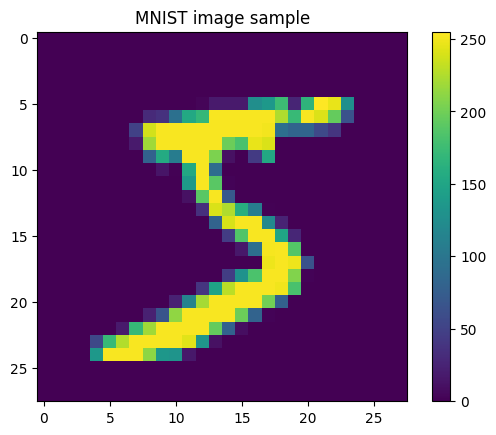

PIL.Image
min: 0, max: 255
Torch.tensor
min: 0.0, max: 1.0


In [11]:
plt.title("MNIST image sample")
cax = plt.imshow(pil_transform(image))
plt.colorbar(cax)
plt.show()

min_val, max_val = pil_transform(image).getextrema()
print(f"PIL.Image")
print(f"min: {min_val}, max: {max_val}")

print(f"Torch.tensor")
print(f"min: {torch.min(image)}, max: {torch.max(image)}")

In [12]:
print(len(train_dataset))

60000


In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, drop_last=True)

In [14]:
print(len(train_dataloader))

468


In [15]:
import torch.nn as nn

In [16]:
class Linear(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super().__init__()

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.layers = self.get_layer()

    def get_layer(self):
        layers = nn.ModuleList()

        if self.hidden_sizes:
            layers.append(nn.Linear(self.input_size, self.hidden_sizes[0]))
            if len(self.hidden_sizes) >= 2:
                for idx in range(1, len(self.hidden_sizes)):
                    layers.append(nn.Linear(self.hidden_sizes[idx-1], self.hidden_sizes[idx]))
            layers.append(nn.Linear(self.hidden_sizes[-1], self.num_classes))

        else:
            layers.append(nn.Linear(self.input_size, self.num_classes))

        return layers
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [17]:
# hidden이 없을 때
model = Linear(784, None, 10)
print(model.layers)

ModuleList(
  (0): Linear(in_features=784, out_features=10, bias=True)
)


In [18]:
# hidden이 1개 일 때
model = Linear(784, [100], 10)
print(model.layers)

ModuleList(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=10, bias=True)
)


In [19]:
# hidden이 2개 이상일 때
model = Linear(784, [100, 50], 10)
print(model.layers)

ModuleList(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=50, bias=True)
  (2): Linear(in_features=50, out_features=10, bias=True)
)


In [20]:
output = model(image.unsqueeze(0))
print(output.shape)

torch.Size([1, 10])


In [21]:
output

tensor([[ 0.0712,  0.0777,  0.1549,  0.0445,  0.1349,  0.1022,  0.0317,  0.0773,
         -0.0918, -0.1292]], grad_fn=<AddmmBackward0>)

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
loss = criterion(input=output, target=torch.tensor(label).unsqueeze(0))
loss

tensor(2.2514, grad_fn=<NllLossBackward0>)

In [24]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [25]:
input

tensor([[-0.1043,  0.9673,  1.5353,  0.1005, -0.2945],
        [-0.9489,  1.2327,  1.2910, -0.9176,  1.0711],
        [ 0.4556,  0.7672, -1.0799, -0.4684,  0.1048]], requires_grad=True)

In [26]:
input.shape

torch.Size([3, 5])

In [27]:
target

tensor([4, 1, 3])

In [28]:
target.shape

torch.Size([3])

In [29]:
output

tensor(1.9904, grad_fn=<NllLossBackward0>)

In [30]:
sum(input)

tensor([-0.5975,  2.9673,  1.7464, -1.2855,  0.8814], grad_fn=<AddBackward0>)

In [31]:
import torch.optim as optim

In [32]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

criterion.to(device)
model.to(device)

Linear(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [34]:
test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)
test_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=8)

In [35]:
predict_score = 0
num_samples = 0
for (x, y) in test_dataloader:
    num_samples += y.size(0)
    x = x.to(device)

    output = model(x)
    output_idx = output.argmax(dim=1).cpu()

    sum = (output_idx == y).sum().item()
    predict_score += sum

accuracy = predict_score / num_samples
print(f"accuracy: {accuracy:.4f}")

accuracy: 0.1475


In [36]:
for epoch in range(101):
    for (x, y) in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)
        loss = criterion(output, y)

        loss.backward()

        optimizer.step()

    if epoch % 10 == 0:
        print(f"{epoch}/100: loss: {loss:.4f}")

0/100: loss: 2.2270
10/100: loss: 0.8995
20/100: loss: 0.6083
30/100: loss: 0.6030
40/100: loss: 0.4479
50/100: loss: 0.3011
60/100: loss: 0.3778
70/100: loss: 0.2608
80/100: loss: 0.2479
90/100: loss: 0.3756
100/100: loss: 0.3230


In [37]:
predict_score = 0
num_samples = 0
for (x, y) in test_dataloader:
    num_samples += y.size(0)
    x = x.to(device)

    output = model(x)
    output_idx = output.argmax(dim=1).cpu()

    sum = (output_idx == y).sum().item()
    predict_score += sum

accuracy = predict_score / num_samples
print(f"accuracy: {accuracy:.4f}")

accuracy: 0.9102


In [39]:
from torch.utils.data import random_split

In [40]:
a, b = random_split(train_dataset, [0.8, 0.2])

In [41]:
print(len(train_dataset))

60000


In [42]:
print(len(a))

48000


In [43]:
print(len(b))

12000
